In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
def search_images(term,max_images=30):
    print("Searching for",term)
    return L(ddg_images(term,max_results=max_images)).itemgot('image')

In [2]:
urls=search_images('grizzly bear',max_images=1)
urls[0]

Searching for grizzly bear


C:\Users\Kesha\conda3\Lib\site-packages\duckduckgo_search\compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
C:\Users\Kesha\conda3\Lib\site-packages\duckduckgo_search\compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
C:\Users\Kesha\conda3\Lib\site-packages\duckduckgo_search\compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg'

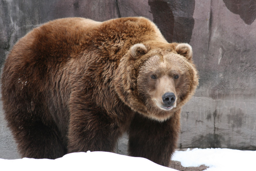

In [3]:
from fastdownload import download_url
dest='images/grizzly.jpg'
download_url(urls[0],dest,show_progress=False)

from fastai.vision.all import *
im=Image.open(dest)
im.to_thumb(256,256)

In [18]:
from fastai.imports import *
import fastai
bear_types='grizzly','black','teddy'
path=Path('bears')

for o in bear_types:
    dest=path/o
    dest.mkdir(exist_ok=True,parents=True)
    download_images(dest,urls=search_images(f'{o} bear photos'))
    resize_images(path/o,max_size=400,dest=path/o)

Searching for grizzly bear photos
Searching for black bear photos
Searching for teddy bear photos


In [21]:
fns=get_image_files(path)
fns

(#456) [Path('bears/black/0071dab9-c020-41b2-bf3e-c36aceb9e81c.jpg'),Path('bears/black/018a3a83-3be5-4633-844c-c8d7520fcaa2.jpg'),Path('bears/black/0334d542-72da-440e-906c-dfa13c68442a.jpg'),Path('bears/black/08afd9ae-3c49-460f-8ac7-d20185331fcf.jpg'),Path('bears/black/0982cd55-16cb-4b38-9ca0-91a8942c739f.jpg'),Path('bears/black/09b716f2-8b71-4ad9-b6f2-29d52b6a1caa.jpg'),Path('bears/black/0a158d09-dfe1-4647-9b82-28e151b25fea.jpg'),Path('bears/black/0b4bb3c3-da16-4ac2-810b-bcd536d7e25b.jpg'),Path('bears/black/10fecd61-6381-456c-956d-e23711e147f2.jpg'),Path('bears/black/11310d28-0bb1-4f8a-a175-d7612b3649e3.jpg')...]

In [22]:
failed=verify_images(fns)
failed

(#0) []

In [24]:
failed.map(Path.unlink);

In [25]:
bears=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [26]:
dls=bears.dataloaders(path)

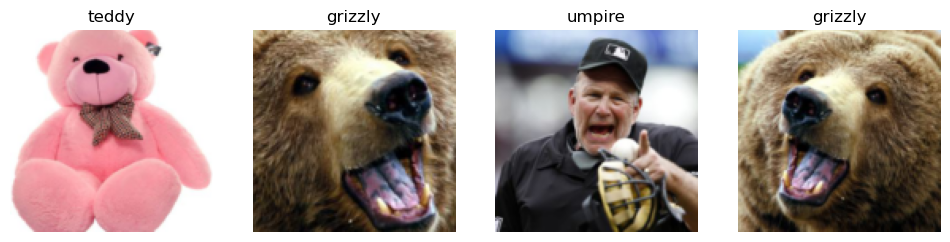

In [27]:
dls.valid.show_batch(max_n=4,nrows=1)

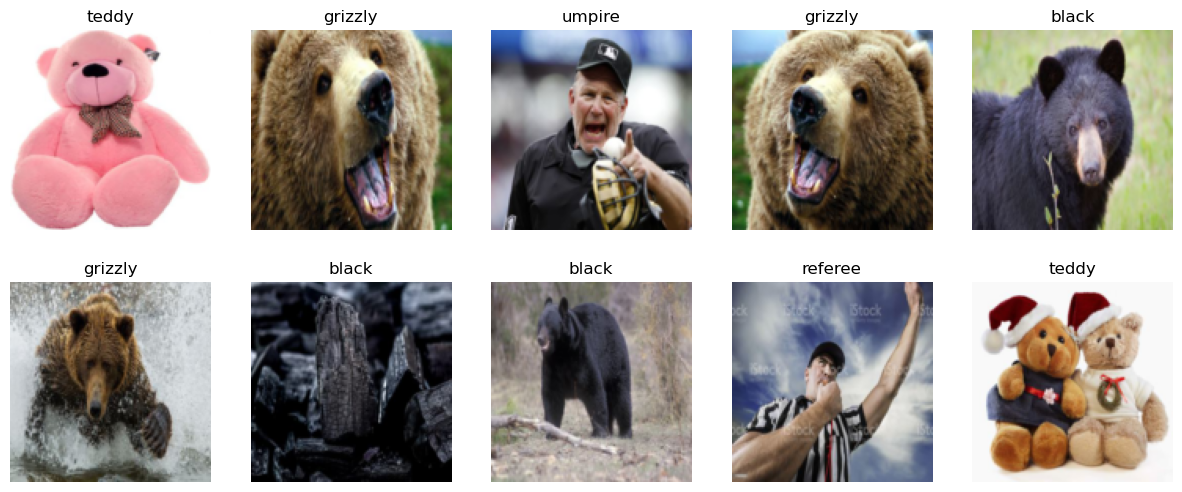

In [28]:
bears=bears.new(item_tfms=Resize(128,ResizeMethod.Squish))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=10,nrows=2)

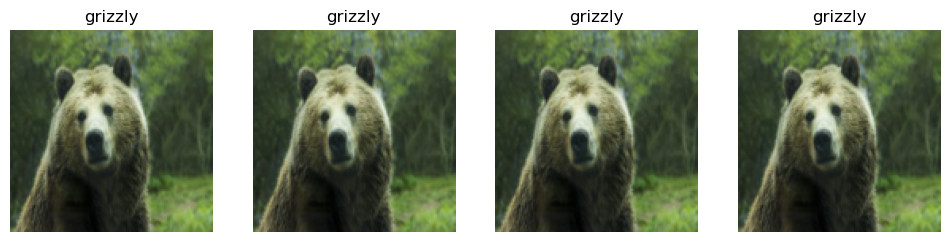

In [29]:
bears=bears.new(item_tfms=Resize(128,ResizeMethod.Squish))
dls=bears.dataloaders(path)
dls.train.show_batch(max_n=4,nrows=1,unique=True)

In [31]:
learn=vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(4)

C:\Users\Kesha\conda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kesha\conda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.891326,0.671689,0.252747,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.610095,0.221149,0.065934,00:30
1,0.383438,0.132299,0.043956,00:30
2,0.257869,0.086021,0.010989,00:31
3,0.189510,0.074221,0.010989,00:30


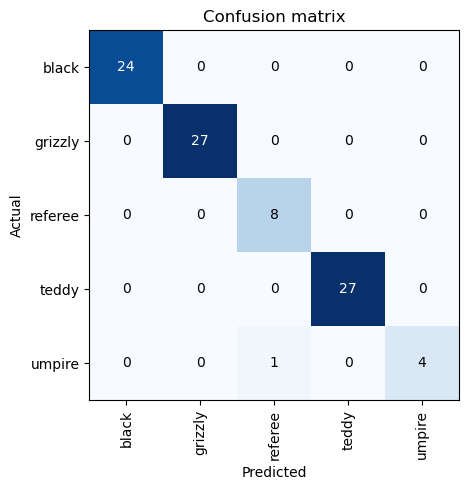

In [33]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

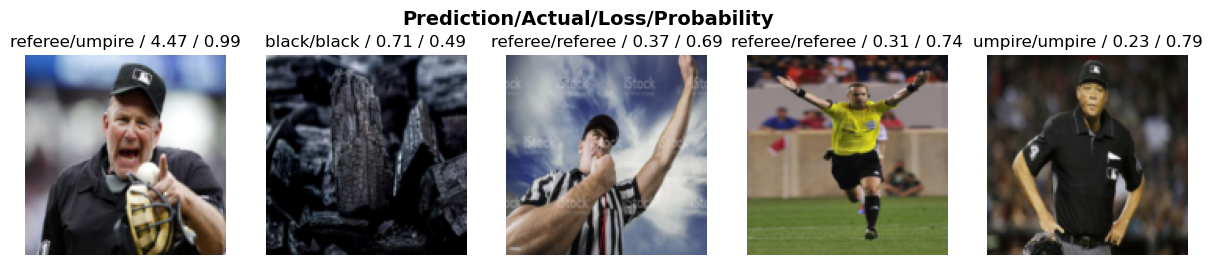

In [34]:
interp.plot_top_losses(5,nrows=1)

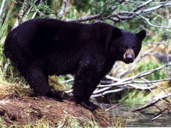

In [38]:
from fastai.vision.widgets import *
cleaner=ImageClassifierCleaner(learn)
cleaner

In [40]:
for idx in cleaner.delete():cleaner.fns[idx].unlink()

In [41]:
learn.export()

In [42]:
path=Path()

In [44]:
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [45]:
learn_inf=load_learner(path/'export.pkl')

In [46]:
learn_inf.predict('images/grizzly.jpg')

('grizzly',
 tensor(1),
 tensor([5.0579e-11, 1.0000e+00, 1.2679e-06, 5.1749e-09, 1.1996e-07]))

In [49]:
learn_inf.dls.vocab

['black', 'grizzly', 'referee', 'teddy', 'umpire']

In [51]:
btn_upload=widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [52]:
btn_upload=SimpleNamespace(data=['images/grizzly.jpg'])

In [53]:
img=PILImage.create(btn_upload.data[-1])

In [66]:
out_pl=widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [67]:
pred,pred_idx,probs=learn_inf.predict(img)

In [68]:
lbl_pred=widgets.Label()

In [69]:
lbl_pred.value=f'Prediction: {pred};Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly;Probability: 1.0000')

In [70]:
btn_run=widgets.Button(Description='Classify')
btn_run

Button(style=ButtonStyle())

In [71]:
def on_click_classify(change):
    img=PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with outpl: display(img.to_thumb(128,128))
    pred,pred_ix,probs=learn_inf.predict(img)
    lbl_pred.value=f'Prediction: {pred};Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)    

In [72]:
btn_upload=widgets.FileUpload()

In [76]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])


In [77]:
!pip install voila


In [78]:
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: C:\Users\Kesha\conda3\etc\jupyter
    - Validating...
      voila 0.4.1 ok
